In [1]:
import os
import csv
import copy
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False 

%matplotlib notebook

## 必要的函数

In [8]:
def getTNumberAndRate(Signal):
    '''
    函数功能：
        求给定脉象信号的准周期T对应的数据点长度TNumber，采样率为200Hz
    输入：
        一段脉象信号向量
    输出：
        1.脉象信号的准周期长度T对应的数据点长度TNumber，int类型
        2.脉象信号的脉率，单位是次数/每分钟，int类型
    '''
    import numpy as np
    from scipy.fftpack import fft
    
    fs = 200
    Power = abs(fft(Signal))
    Power = Power[0:100]
    loc = np.where(Power==max(Power))[0][0]
    zhuPin = loc/10 # 主频
    T = 1/zhuPin 
    TNumber = int(round(T*fs)) # 四舍五入
    Rate = int(round(60*zhuPin))
    return TNumber,Rate

def getRateArray(threePressureSignal):
    '''
    函数功能：
        利用getTNumberAndRate函数计算三压力脉象图的脉率
    输入：
        threePressureSignal：一个三压力脉象图数据，array数据类型
        threePressureSignal[0]:浮压力下脉象信号数据
        threePressureSignal[1]:中压力下脉象信号数据
        threePressureSignal[2]:沉压力下脉象信号数据
    输出：
        1.rateArray:依次由浮取、中取、沉取脉象信号波形的脉率组成的向量
        2.该三压力脉象图的平均脉率
    '''
    fuSignal = threePressureSignal[0]
    zhongSignal = threePressureSignal[1]
    chenSignal = threePressureSignal[2]
    
    _,rate1 = getTNumberAndRate(fuSignal)
    _,rate2 = getTNumberAndRate(zhongSignal)
    _,rate3 = getTNumberAndRate(chenSignal)
    
    rateArray = np.array([rate1,rate2,rate3])
    
    return rateArray,np.mean(rateArray)


def RMS(Signal):
    '''
    函数功能：
        计算给定信号向量的均分根幅度值
    输入：
        一段脉象信号向量
    输出：
        该信号的均方根幅度值
    '''
    import numpy as np
    
    return np.sqrt( sum([i**2 for i in Signal])/len(Signal) ) 


def getRMSArray(threePressureSignal):
    '''
    函数功能：
        利用RMS函数计算一个三压力脉象数据的均方根幅度趋势向量，以及脉象强度（平均均方根幅度值）
    输入：
        threePressureSignal：一个三压力脉象图数据，array数据类型
        threePressureSignal[0]:浮压力下脉象信号数据
        threePressureSignal[1]:中压力下脉象信号数据
        threePressureSignal[2]:沉压力下脉象信号数据
    输出：
        1.一个array向量，依次包含浮、中、沉取下脉象的均方根幅度值
        2.该三压力脉象图的平均均方根幅度值，代表脉象强度
    '''
    fuSignal = threePressureSignal[0]
    zhongSignal = threePressureSignal[1]
    chenSignal = threePressureSignal[2]
    
    RMSArray = []
    RMSArray.append(RMS(fuSignal))
    RMSArray.append(RMS(zhongSignal))
    RMSArray.append(RMS(chenSignal))
    
    return np.array(RMSArray),np.mean(RMSArray)

def classFuOrChen(RMSArray):
    '''
    函数功能：
        通过计算三压力脉象图的均方根幅度值趋势图两端的斜率方向来判断脉象是否是是浮脉、沉脉，还是都不是
    
    输入：
        RMSArray:一个array向量，依次包含浮、中、沉取下脉象的均方根幅度值
    输出：
        输出为-1,0,1值
        -1:浮脉
        1:沉脉
        0:既不是浮脉也不是沉脉
    '''
    
    k1 = RMSArray[1]-RMSArray[0]
    k2 = RMSArray[2]-RMSArray[1]
    k = [k1,k2]
    return np.sign(np.sum(np.sign(k)))



def printFuOrChen(RMSArray):
    '''
    函数功能：
        利用RMSArray调用classFuOrChen函数打印判断结果
    输入：
        RMSArray:一个array向量，依次包含浮、中、沉取下脉象的均方根幅度值
    输出：
        无
    '''
    if classFuOrChen(RMSArray)==-1:
        print('浮脉')
        return '浮脉'
    elif classFuOrChen(RMSArray)==1:
        print('沉脉')
        return '沉脉'
    else:
        print('即不是浮脉也不是沉脉')
        return 0

def classXuOrShi(threePressureSignal,LowerBound=1.0,UpperBound=1.2):
    '''
    函数功能：
        用于判断一个三压力脉象图是实脉还是虚脉
    输入：
        1.threePressureSignal：三压力脉象图向量，依次包含浮取、中取、沉取脉象信号向量；
        2.LowerBound：人为设置的虚脉的脉象强度上限；
        3.UpperBound：人为设置的实脉的脉象强度下限；脉象强度在LowerBound与UpperBound之间为正常脉；
    输出：
        实脉还是虚脉的判断
    '''
    RMSArray,Power = getRMSArray(threePressureSignal)
    
    if Power < LowerBound:
        return '虚脉'
    elif Power > UpperBound:
        return '实脉'
    else:
        return '平脉'
    
def TCMPulseRecognition(threePressureSignal,LowerBound=1.0,UpperBound=1.2):
    '''
    函数功能：
        用于判断一个三压力脉象图是迟脉、数脉、浮脉、沉脉、虚脉、实脉、平脉中的哪一种
    输入：
        1.threePressureSignal：三压力脉象图向量，依次包含浮取、中取、沉取脉象信号向量；
        2.LowerBound：人为设置的虚脉的脉象强度上限；
        3.UpperBound：人为设置的实脉的脉象强度下限；脉象强度在LowerBound与UpperBound之间为正常脉；
    输出：
        迟脉、数脉、浮脉、沉脉、虚脉、实脉、平脉中的一种
    '''
    
    rateArray,rate = getRateArray(threePressureSignal)
    RMSArray,Power = getRMSArray(threePressureSignal)
    
    if rate <= 70:
        return '迟脉'
    elif rate >= 90:
        return '数脉'
    else:
        if classFuOrChen(RMSArray)==-1:
            return '浮脉'
        elif classFuOrChen(RMSArray)==1:
            return '沉脉'
        else:
            return classXuOrShi(threePressureSignal,LowerBound=1.0,UpperBound=1.2)

def getResult(PulseData):
    classResult = np.array([0,0,0,0,0,0,0])

    result = TCMPulseRecognition(PulseData,LowerBound=1.0,UpperBound=1.2)
    if result=='迟脉':
        classResult[0]=1
    elif result=='数脉':
        classResult[1]=1
    elif result=='浮脉':
        classResult[2]=1
    elif result=='沉脉':
        classResult[3]=1
    elif result=='虚脉':
        classResult[4]=1
    elif result=='实脉':
        classResult[5]=1
    else:
        classResult[6]=1
        
    return classResult

In [ ]:
def plotResult(plotData,pictureFileName):

    %matplotlib notebook
    fig = plt.figure() 
    ##########################################################################
    '''1.三压力脉象图'''
    plt.subplot2grid((5,3),(0,0),rowspan = 2, colspan = 2)
    plt.title('三压力脉象图')
    t = np.linspace(0,10,num=2000)
    plt.plot(t,plotData[0]+20,label='浮取脉图')
    plt.plot(t,plotData[1]+10,label='中取脉图')
    plt.plot(t,plotData[2],label='沉取脉图')
    plt.legend()
    plt.grid(axis='x' )

    # plt.xlabel('时间/秒')
    # plt.ylabel('幅度值')

    ##########################################################################
    '''2.脉率值图'''
    plt.subplot2grid((5,3),(0,2),rowspan = 2)
    plt.title('脉率值图')

    rateArray,rate = getRateArray(plotData)

    plt.plot(rate,'r^',markersize=5)
    plt.text(0, rate, int(rate), ha='center', va='bottom', fontsize=10,color='r')

    plt.text(-0.5, 62, '迟脉区', ha='center', va='bottom', fontsize=10)
    plt.text(-0.5, 93, '数脉区', ha='center', va='bottom', fontsize=10)

    plt.ylim([int(rate)-30,int(rate)+30])
    plt.xlim([-1,1])
    plt.tick_params(bottom=True, top=False, left=True, right=False)

    # plt.axhline(y=60,ls=":",c="blue")  #迟脉线
    plt.axhline(y=70,ls="--",c="yellow",lw = 3)  #缓脉线
    plt.axhline(y=90,ls="--",c="red",lw = 3)     #数脉线
    # plt.axhline(y=120,ls=":",c="green") #迟脉线

    plt.ylabel('次数/分钟')
    
    ##########################################################################
    '''3.浮中沉强度趋势图'''
    plt.subplot2grid((5,3),(2,0),rowspan = 2, colspan = 2)
    plt.title('浮中沉强度趋势图')

    RMSArray,RMSmean = getRMSArray(plotData)

    plt.plot(RMSArray)
    plt.plot(0,RMSArray[0],'v',label=' 浮')
    plt.plot(1,RMSArray[1],'v',label=' 中')
    plt.plot(2,RMSArray[2],'v',label=' 沉')
    plt.legend()
    plt.ylabel('脉强值')
   
    ##########################################################################
    '''4.平均强度值图'''
    plt.subplot2grid((5,3),(2,2),rowspan = 2)
    plt.title('平均强度值图')
    plt.plot(RMSmean,'v',markersize=5)

    plt.axhline(y=1,ls="-.",c="b",lw = 1)  #缓脉线
    plt.axhline(y=1.2,ls="-.",c="y",lw = 1)  #缓脉线

    plt.text(0, RMSmean, '%.2f'%RMSmean, ha='center', va='bottom', fontsize=10,color='r')

    plt.text(-0.5, 1.3, '实脉区', ha='center', va='bottom', fontsize=10)
    plt.text(-0.5, 0.7, '虚脉区', ha='center', va='bottom', fontsize=10)

    plt.ylim([0,2.5])
    plt.xlim([-1,1])
    plt.ylabel('脉强值')
    
    ##########################################################################
    plt.subplot2grid((5,3),(4,0),colspan = 3)
    plt.title('诊断结果')
    xbar = ['迟脉','数脉','浮脉','沉脉','虚脉','实脉','平脉']
    ybar = getResult(plotData)
    plt.bar(range(len(xbar)),ybar)

#     plt.xticks(range(len(xbar)), xbar)
    
    ##########################################################################
#     fig.suptitle(pictureName,x=0.5,y=1.05)
    # 这样这个函数就类似于 adjust_subplots
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(pictureFileName,dpi=600)#, bbox_inches='tight')
    
#     plt.show()

## 导入数据

In [3]:
def getFileName(Path):
    csvFiles = []
    for dirname, _, filenames in os.walk(Path):
        for filename in filenames:
            fullPath = os.path.join(dirname, filename)
            if filename.endswith("csv"):
                csvFiles.append(fullPath)
                
    return csvFiles

Path ='1.原始数据/1.迟脉/数据'

csvFilePaths = getFileName(Path)

In [5]:
csvFilePaths[23]

'1.原始数据/1.迟脉/数据\\60_.csv'

In [7]:
bothData = pd.read_csv(open(csvFilePaths[23],encoding= 'utf-8'),header=None).values 

In [9]:
getResult(bothData)

array([1, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>


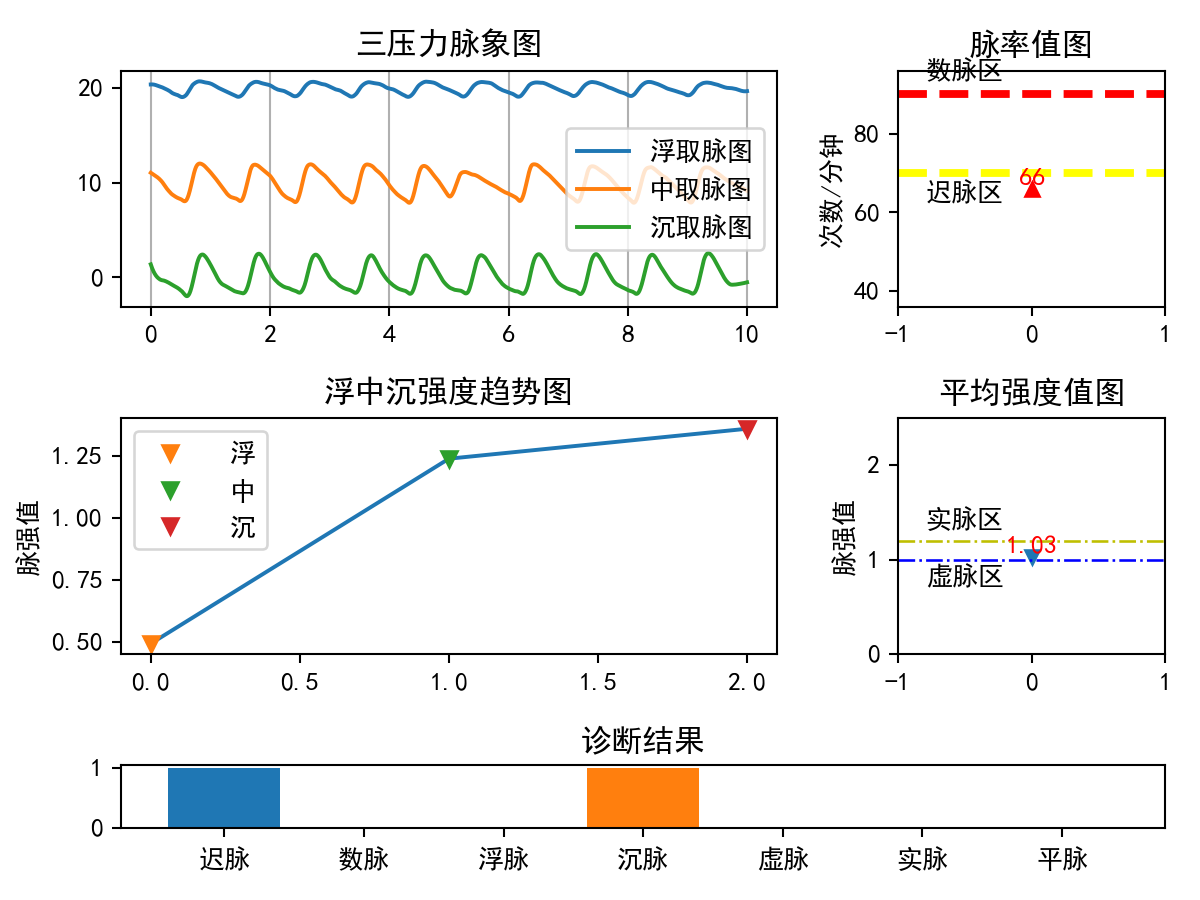

In [12]:
plotData = bothData

fig = plt.figure() 
##########################################################################
'''1.三压力脉象图'''
plt.subplot2grid((5,3),(0,0),rowspan = 2, colspan = 2)
plt.title('三压力脉象图')
t = np.linspace(0,10,num=2000)
plt.plot(t,plotData[0]+20,label='浮取脉图')
plt.plot(t,plotData[1]+10,label='中取脉图')
plt.plot(t,plotData[2],label='沉取脉图')
plt.legend()
plt.grid(axis='x' )

# plt.xlabel('时间/秒')
# plt.ylabel('幅度值')

##########################################################################
'''2.脉率值图'''
plt.subplot2grid((5,3),(0,2),rowspan = 2)
plt.title('脉率值图')

rateArray,rate = getRateArray(plotData)

plt.plot(rate,'r^',markersize=5)
plt.text(0, rate, int(rate), ha='center', va='bottom', fontsize=10,color='r')

plt.text(-0.5, 62, '迟脉区', ha='center', va='bottom', fontsize=10)
plt.text(-0.5, 93, '数脉区', ha='center', va='bottom', fontsize=10)

plt.ylim([int(rate)-30,int(rate)+30])
plt.xlim([-1,1])
plt.tick_params(bottom=True, top=False, left=True, right=False)

# plt.axhline(y=60,ls=":",c="blue")  #迟脉线
plt.axhline(y=70,ls="--",c="yellow",lw = 3)  #缓脉线
plt.axhline(y=90,ls="--",c="red",lw = 3)     #数脉线
# plt.axhline(y=120,ls=":",c="green") #迟脉线

plt.ylabel('次数/分钟')

##########################################################################
'''3.浮中沉强度趋势图'''
plt.subplot2grid((5,3),(2,0),rowspan = 2, colspan = 2)
plt.title('浮中沉强度趋势图')

RMSArray,RMSmean = getRMSArray(plotData)

plt.plot(RMSArray)
plt.plot(0,RMSArray[0],'v',label=' 浮')
plt.plot(1,RMSArray[1],'v',label=' 中')
plt.plot(2,RMSArray[2],'v',label=' 沉')
plt.legend()
plt.ylabel('脉强值')

##########################################################################
'''4.平均强度值图'''
plt.subplot2grid((5,3),(2,2),rowspan = 2)
plt.title('平均强度值图')
plt.plot(RMSmean,'v',markersize=5)

plt.axhline(y=1,ls="-.",c="b",lw = 1)  #缓脉线
plt.axhline(y=1.2,ls="-.",c="y",lw = 1)  #缓脉线

plt.text(0, RMSmean, '%.2f'%RMSmean, ha='center', va='bottom', fontsize=10,color='r')

plt.text(-0.5, 1.3, '实脉区', ha='center', va='bottom', fontsize=10)
plt.text(-0.5, 0.7, '虚脉区', ha='center', va='bottom', fontsize=10)

plt.ylim([0,2.5])
plt.xlim([-1,1])
plt.ylabel('脉强值')

##########################################################################
plt.subplot2grid((5,3),(4,0),colspan = 3)
plt.title('诊断结果')
xbar = ['迟脉','数脉','浮脉','沉脉','虚脉','实脉','平脉']
ybar = np.array([1, 0, 0, 0, 0, 0, 0])
ybar2 = np.array([0, 0, 0, 1, 0, 0, 0])
plt.bar(range(len(xbar)),ybar)
plt.bar(range(len(xbar)),ybar2)

plt.xticks(range(len(xbar)), xbar)

##########################################################################

plt.tight_layout()
# plt.savefig(pictureFileName,dpi=600)#, bbox_inches='tight')
plt.savefig(r'C:\Users\ASUS\Desktop\毕业论文PPT作图汇总\第四章\图4-7.png',dpi=600, bbox_inches='tight')
plt.show()